# Machine Learning for Language Detection Using Multinomial Logistic Regression and the N-gram Approach

## Submission by Richard Lipkin, PhD (richlipkin@gmail.com)

#### Purpose: to train a machine learning model with data from the [European Parliament Proceedings Parallel Corpus](http://www.statmt.org/europarl/) to predict the languages used in passages from the [test set](https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/language-detection/europarl-test.zip).

Language detection via machine learning is a topic about which a significant amount of research has already been done. Several established methods are capable of achieving relatively high accuracy at language assignment of text passages. Therefore, this challenge solution extends the techniques employed by previous projects. The following sources were extremely helpful with the preparation of this work:

1. [Cavnar, WB, Trenkle, JM. N-Gram-Based Text Categorization. 1994.](http://www.let.rug.nl/vannoord/TextCat/textcat.pdf)
1. [Shuyo N. Language Detection with Infinity-Gram. 2011.](https://github.com/shuyo/ldig)
1. [Pampel FC. Logistic Regression: A Primer. 2000.](https://books.google.com/books?id=3wFADQAAQBAJ&printsec=frontcover#v=onepage&q&f=false)
1. [Tunguz B. Logistic Regression with Words and Char N-Grams. 2018.](https://www.kaggle.com/tunguz/logistic-regression-with-words-and-char-n-grams)
1. [Triglia S. Elegant N-gram Generation in Python. 2013.](http://locallyoptimal.com/blog/2013/01/20/elegant-n-gram-generation-in-python/)
1. [Balachandra N. Language Detection MultinomialLogisticRegression. 2017.](https://github.com/niharikabalachandra/Language-Detection-MultinomialLogisticRegression)
1. [Scikit-learn developers. Feature Extraction. 2007-2017.](http://scikit-learn.org/stable/modules/feature_extraction.html)

<a id="0"></a>
# 0. Import

Let's get started by importing all of the packages we will need.

In [1]:
import glob
import csv
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from prettytable import PrettyTable

<a id="1"></a>
## 1. Define function to read files from a folder and return a list of all words in the files

Next, we define the data extraction function.

As per [Cavnar 1994](http://www.let.rug.nl/vannoord/TextCat/textcat.pdf), relatively short training sets still produce good results. Therefore, to reduce processing time, we limit the input to a certain word count for each language.

The results of a preliminary study (results shown in comments below) indicated that for character N-grams, we reached diminishing returns in terms of accuracy at wordcount = 150000. However, for word N-grams, we continued to gain accuracy until wordcount = 750000. Therefore, it seems that character-based N-gram models reach maximum accuracy at smaller dataset sizes than word-based N-gram models for this dataset.

We did not increase wordcount further due to limitations of the available computational resources.

In [3]:
def dataExtraction(path):
    list_of_files= glob.glob(path)
    text_add= []
    wordcount= 750000   # Wordcount was set empirically to yield an appropriate word count for 
                        # each language in the denoised dataset
                        # At wordcount= 15000, cumulative character and word model classification 
                        # accuracy maxed out at 90% and 58%, respectively
                        # At wordcount= 150000, cumulative character and word model classification 
                        # accuracy maxed out at 92% and 72%, respectively
                        # At wordcount= 750000, cumulative character and word model classification 
                        # accuracy maxed out at 92.6% and 79%, respectively 
    for fileName in list_of_files:
            if len(text_add) >= wordcount: # Break once we reach the max word count for each language
                    break
            data= open(fileName)
            data= data.read()
            text= data.split(' ') # Split words according to spaces
            for i in text:
                if (i!='ID' and i!='NAME' and i!='SPEAKER' and i!='CHAPTER' and i!='LANGUAGE' and  
                    i!='<P>' and len(text_add) < wordcount):
                    text_add.append(i) # Ignore markup text and use only the first 
                                       # (wordcount) words for each language
                elif len(text_add) >= wordcount: 
                    break
    return(text_add) # Returns list of words in a given text file

<a id="2"></a>
## 2. Define function to remove noise from data

Next, we define a function to remove all irrelevant characters/words from the extracted text. We will use this on both the training and test sets.

In [3]:
def removeNoise (data,index): # We pass it an index because the training and test data 
                              # will have different indices
    data[index]= data[index].str.replace('\s', ' ')
    data[index]= data[index].str.replace('ID', ' ')
    data[index]= data[index].str.replace('NAME', ' ')
    data[index]= data[index].str.replace('SPEAKER', ' ')
    data[index]= data[index].str.replace('CHAPTER', ' ')
    data[index]= data[index].str.replace('LANGUAGE', ' ')
    data[index]= data[index].str.replace('<P>', ' ')
    data[index]= data[index].str.replace('/', ' ')
    data[index]= data[index].str.replace('[=<>":-;.,\(\)]', ' ')
    data[index]= data[index].str.replace('-', ' ')
    data[index]= data[index].str.replace('?', ' ')
    data[index]= data[index].str.replace('[0-9]', ' ')
    for i in range (9):
        data[index]= data[index].str.replace('  ', ' ') # Reduces multiple consecutive spaces
    data[index]= data[index].str.strip()
    data= data[data[index] != '']
    data= data.drop_duplicates()
    data= data.dropna()
    return(data)

<a id="3"></a>
## 3. Define function to join a series of words from a given language and place them into a list

We next define a function to join a series of disjointed words into a continuous passage of text.

We make sure that the dataset for each language starts and ends with a space, so that the N-gram construction can start one character before the beginning of the first word. This reduces bias, as per [Cavnar 1994](http://www.let.rug.nl/vannoord/TextCat/textcat.pdf).

In [4]:
def listToText(Series): 
    
    Series_list= Series[0].tolist()
    Series_str= ' '.join(Series_list)
    Series_str_space = ' ' + Series_str + ' ' # Add a space to the beginning and end of the data 
                                              # for each language, following Cavnar
    return(Series_str_space)

<a id="4"></a>
## 4. Create list of all languages for which classification data are present

These 21 categorical variables are the outputs of our classifier, and they are also the subdirectory names from which to scrape input files. We train the models using information about which training text passages correspond to each of these languages, and we classify each of the test passages as belonging to one of these languages.

- 'bg': Bulgarian
- 'cs': Czech
- 'da': Danish
- 'de': German
- 'el': Greek
- 'en': English
- 'es': Spanish
- 'et': Estonian
- 'fi': Finnish
- 'fr': French
- 'hu': Hungarian
- 'it': Italian
- 'lt': Lithuanian
- 'lv': Latvian
- 'nl': Dutch
- 'pl': Polish
- 'pt': Portuguese
- 'ro': Romanian
- 'sk': Slovak
- 'sl': Slovenian
- 'sv': Swedish

In [4]:
labels=['bg','cs','da','de','el','en','es','et','fi','fr','hu','it','lt','lv','nl','pl','pt',
        'ro','sk','sl','sv']

<a id="5"></a>
## 5. Read in raw text files to obtain training data

We then feed the raw training text into the functions defined above to yield passages of continuous, denoised text.

In [6]:
paths= []
base_path= 'europarl/txt/' # The directory in which all EuroParl dataset text files are stored
a=[]
b=[]
data=[]
data_str=[]
i= 0

for label in labels:
    paths.append(base_path + label + '/*.txt')
    print('Now processing: ' + paths[i]) # Progress notification
    a.append (dataExtraction(paths[i])) # Call the dataExtraction function on the paths for each language
    b.append (pd.DataFrame(a[i]))
    data.append(removeNoise(b[i],0)) # Call the removeNoise function defined above on the extracted data
    data_str.append(listToText(data[i])) # Transform the list of words into a continuous text passage
    i+=1
        
# print(paths) # We can print the list of paths if we want to verify that the path assignment is correct

Now processing: europarl/txt/bg/*.txt
Now processing: europarl/txt/cs/*.txt
Now processing: europarl/txt/da/*.txt
Now processing: europarl/txt/de/*.txt
Now processing: europarl/txt/el/*.txt
Now processing: europarl/txt/en/*.txt
Now processing: europarl/txt/es/*.txt
Now processing: europarl/txt/et/*.txt
Now processing: europarl/txt/fi/*.txt
Now processing: europarl/txt/fr/*.txt
Now processing: europarl/txt/hu/*.txt
Now processing: europarl/txt/it/*.txt
Now processing: europarl/txt/lt/*.txt
Now processing: europarl/txt/lv/*.txt
Now processing: europarl/txt/nl/*.txt
Now processing: europarl/txt/pl/*.txt
Now processing: europarl/txt/pt/*.txt
Now processing: europarl/txt/ro/*.txt
Now processing: europarl/txt/sk/*.txt
Now processing: europarl/txt/sl/*.txt
Now processing: europarl/txt/sv/*.txt


### 5a. Output dataset sizes before and after denoising and a sample head to verify correct data input and processing

In [7]:
for i in range(len(labels)):
    print(labels[i] + ' a ' + str(len(a[i])))
    print(labels[i] + ' b ' + str(len(b[i])))
    print(labels[i] + ' data ' + str(len(data[i])))
    # print(data_str[i]) # This prints the raw data string to check for formatting issues
    
data[0].head(10)


bg a 750000
bg b 750000
bg data 48042
cs a 750000
cs b 750000
cs data 61713
da a 750000
da b 750000
da data 42248
de a 750000
de b 750000
de data 46635
el a 750000
el b 750000
el data 45738
en a 750000
en b 750000
en data 26502
es a 750000
es b 750000
es data 35812
et a 750000
et b 750000
et data 82030
fi a 750000
fi b 750000
fi data 92770
fr a 750000
fr b 750000
fr data 33531
hu a 750000
hu b 750000
hu data 82563
it a 750000
it b 750000
it data 38336
lt a 750000
lt b 750000
lt data 74270
lv a 750000
lv b 750000
lv data 61898
nl a 750000
nl b 750000
nl data 34482
pl a 750000
pl b 750000
pl data 63889
pt a 750000
pt b 750000
pt data 37632
ro a 750000
ro b 750000
ro data 41512
sk a 750000
sk b 750000
sk data 64166
sl a 750000
sl b 750000
sl data 53806
sv a 750000
sv b 750000
sv data 45235


,0
1,Състав
2,на
3,Парламента
4,вж
5,протоколи
7,Одобряване
9,протокола
10,от
11,предишното
12,заседание


### 5b. Create a dataframe containing the strings from each language

In [8]:
trainingData= pd.DataFrame(data_str)
trainingData

,0
0,Състав на Парламента вж протоколи Одобряване ...
1,Schválení zápisu z předchozího zasedání viz z...
2,Genoptagelse af sessionen Formanden Jeg erklæ...
3,Wiederaufnahme der Sitzungsperiode Die Präsid...
4,Επαvάληψη της συvσδoυ Πρόεδρος Κηρύσσω την επ...
5,Resumption of the session President I declare...
6,Reanudación del período de sesiones La Presid...
7,Eelmise istungi protokolli kinnitamine vaata ...
8,Istuntokauden uudelleenavaaminen Puhemies Jul...
9,Reprise de la session La Présidente Je déclar...


<a id="6"></a>
## 6. Build various models and train them with the training data
#### N-gram frequency analysis for both characters and words uses a multinomial logistic regression model. 

> Why this instead of Naive Bayes? Because it does not assume that the input variables are random i.e. statistically independent.
> To avoid overfitting resulting from strong correlations between the training features, we use L2 (Ridge) regularization. L2 regularization also introduces sparsity and reduces the regression coefficients. The regularization strength is set to 1 so that the models can be adapted to novel data.

#### ___We use the following N-gram types for analysis:___
- A. 1-gram through 6-gram for characters, allowing N-grams to span multiple words
- B. 2-gram through 6-gram for characters, allowing N-grams to span multiple words, also including smaller N-grams (e.g. 3-gram analysis also includes 2-grams and 1-grams; we call these "cumulative" models)
- C. 1-gram through 6-gram for characters, with N-grams only within single words (beginnings and endings of words padded with spaces) 
- D. 4-gram for characters, restricted to the 100, 200, 300, or 400 most common N-grams ("features")
- E. 1-gram and 2-gram for words
- F. 2-gram for words, also including 1-word N-grams (cumulative)

#### Why all these different types of analysis?
- A. Using character N-grams of a specific size is the most basic approach. These N-grams are allowed to span multiple words from the sample texts, so the classification is sensitive to word ordering and context.
- B. We can repeat part A including N-grams of a given size plus all smaller N-gram sizes down to 1. This includes more information, including the frequency of each letter. Some methods, such as [Shuyo's Infinity Gram approach](https://github.com/shuyo/ldig), use a "maximal substring" model that includes all possible substring sizes.
- C. We can also use character N-grams that are restricted to occurring only within single words. To facilitate this, the beginnings and ends of words are padded with spaces. This makes the analysis insensitive to word ordering, context, and passage length.
- D. It would be ideal for the model to work on text about any subject. The [Cavnar 1994](http://www.let.rug.nl/vannoord/TextCat/textcat.pdf) paper mentions that restricting the analysis to the most common N-grams can eliminate sensitivity to topic-specific information in the text. They suggest restricting analysis to the 100, 200, 300, or 400 most common N-grams and stated that using the top 400 features yielded good results. They base this insight on [Zipf's Law](https://simple.wikipedia.org/wiki/Zipf%27s_law).
- E-F. The basic unit of the N-gram can also be an entire word. This is more similar to a dictionary-based approach. The case with N=1 simply uses the frequency of entire words to generate classifications. Word N-grams with N>1 are also sensitive to syntax. We only try a few of these because it is more difficult for these models to accommodate things like misspellings and word modifications such as verb conjugation. (In character-based approaches, many character N-grams may be the same even if a word is misspelled or changed slightly). A word stemming approach would be outside the scope of this project.

#### Why size 1-6 for character N-grams?

- The [Cavnar 1994](http://www.let.rug.nl/vannoord/TextCat/textcat.pdf) paper states that their system used N-grams up to size N=5, but we should also include at least one larger size to verify that the effectiveness of the model deteriorates or levels off as we increase the character N-gram size further.
- Initial experiments with 7-character N-grams showed no classification benefits over using 6-character N-grams, and the processing of 7-character N-grams is quite slow with the present combination of available computational resources and amout of data used for input.

#### This implementation uses the Scikit-learn toolkit, an off-the-shelf solution for n-gram processing, for feature extraction. However, if we wanted to write a method of generating N-grams from scratch, it can be done very simply. An N-gram generation algorithm can actually be implemented in just a single line of Python code, according to [a blog post by Scott Triglia](http://locallyoptimal.com/blog/2013/01/20/elegant-n-gram-generation-in-python/):

<div class="alert alert-block alert-info">
def find_ngrams(input_list, n): <br>
____return zip(*[input_list[i:] for i in range(n)])
</div>


In [9]:
model_ngram_char= []
model_ngram_char_wb= [] # wb models use within-word N-grams
model_ngram_char_cum= []
model_ngram_char_maxf= [] # restricts the maximum number of features
model_ngram_word= []
model_ngram_word_cum= []
n_char_range= 6 # All N-gram sizes from 1 to n_char_range and n_word_range are run
m_word_range= 2
maxf_range= 4 # The numbers of features included in max features models are multiples of 100

for n in range (n_char_range): # Model training is implemented in loops to reduce  number of code lines
    print('Now training: character ' + str(n+1) + '-grams') # Progress notification
    model_ngram_char.append(Pipeline([('vect', CountVectorizer(ngram_range=(n+1,n+1), 
                                                               analyzer='char')), 
                                      ('tfidf', TfidfTransformer(use_idf=False)), 
                                      ('lrg', LogisticRegression(n_jobs=-1))])
                            .fit(trainingData[0], labels))

for o in range (n_char_range):
    print('Now training: character within word ' + str(o+1) + '-grams')
    model_ngram_char_wb.append(Pipeline([('vect', CountVectorizer(ngram_range=(o+1,o+1), 
                                                                  analyzer='char_wb')), 
                                         ('tfidf', TfidfTransformer(use_idf=False)), 
                                         ('lrg', LogisticRegression(n_jobs=-1))])
                               .fit(trainingData[0], labels))

for p in range (n_char_range):
    print('Now training: cumulative character ' + str(p+1) + '-grams plus smaller N-grams')
    model_ngram_char_cum.append(Pipeline([('vect', CountVectorizer(ngram_range=(1,p+1), 
                                                                   analyzer='char')), 
                                          ('tfidf', TfidfTransformer(use_idf=False)), 
                                          ('lrg', LogisticRegression(n_jobs=-1))])
                                .fit(trainingData[0], labels))    
    
for q in range (maxf_range):
    print('Now training: character 4-grams with max ' + str((q+1)*100) + ' features')
    model_ngram_char_maxf.append(Pipeline([('vect', CountVectorizer(ngram_range=(4,4), 
                                                                    analyzer='char', 
                                            max_features=((q+1)*100))), 
                                           ('tfidf', TfidfTransformer(use_idf=False)), 
                                           ('lrg', LogisticRegression(n_jobs=-1))])
                                 .fit(trainingData[0], labels))

for l in range (m_word_range):
    print('Now training: word ' + str(l+1) + '-grams')
    model_ngram_word.append(Pipeline([('vect', CountVectorizer(ngram_range=(l+1,l+1), 
                                                               analyzer='word')), 
                                      ('tfidf', TfidfTransformer(use_idf=False)), 
                                      ('lrg', LogisticRegression(n_jobs=-1))])
                            .fit(trainingData[0], labels))

for m in range (m_word_range):
    print('Now training: cumulative word ' + str(m+1) + '-grams plus smaller N-grams')
    model_ngram_word_cum.append(Pipeline([('vect', CountVectorizer(ngram_range=(1,m+1), 
                                                                   analyzer='word')), 
                                          ('tfidf', TfidfTransformer(use_idf=False)), 
                                          ('lrg', LogisticRegression(n_jobs=-1))])
                                .fit(trainingData[0], labels))
    

Now training: character 1-grams


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Now training: character 2-grams
Now training: character 3-grams
Now training: character 4-grams
Now training: character 5-grams
Now training: character 6-grams
Now training: character within word 1-grams
Now training: character within word 2-grams
Now training: character within word 3-grams
Now training: character within word 4-grams
Now training: character within word 5-grams
Now training: character within word 6-grams
Now training: cumulative character 1-grams plus smaller N-grams
Now training: cumulative character 2-grams plus smaller N-grams
Now training: cumulative character 3-grams plus smaller N-grams
Now training: cumulative character 4-grams plus smaller N-grams
Now training: cumulative character 5-grams plus smaller N-grams
Now training: cumulative character 6-grams plus smaller N-grams
Now training: character 4-grams with max 100 features
Now training: character 4-grams with max 200 features
Now training: character 4-grams with max 300 features
Now training: character 4-gram

<a id="7"></a>
## 7. Import and preprocess the test data

In [10]:
testData=[]

test_data= pd.read_csv('europarl/europarl.test', sep='\t',header=None)
test_data[1]= test_data[1].str.replace('\(.*?\)','')
testData= removeNoise(test_data,1) # Treat the test data in exactly the same way as the training data

testData.head(10) # Output the head of the preprocessed test dataset

,0,1
0,bg,Европа не трябва да стартира нов конкурентен м...
1,bg,Най голямата несправедливост на сегашната обща...
2,bg,Г жо председател г н член на Комисията по прин...
3,bg,Г н председател бих искал да започна с комента...
4,bg,Г н председател въпросът за правата на човека ...
5,bg,Г н председател гласувах в подкрепа на Комисия...
6,bg,Г н председател госпожи и господа в каква пози...
7,bg,Г н председател госпожи и господа неотдавна на...
8,bg,Г н председател след повече от години колониал...
9,bg,Благодаря Ви Сара за сериозното съдействие


<a id="8"></a>
## 8. Use the trained models to make predictions about the test set

In [11]:
pred_ngram_char= []
pred_ngram_char_wb= []
pred_ngram_char_cum= []
pred_ngram_char_maxf= []
pred_ngram_word= []
pred_ngram_word_cum= []

for n in range (n_char_range): # Like the training, the test predictions are implemented in loops
    print('Now predicting: character ' + str(n+1) + '-grams')
    pred_ngram_char.append(model_ngram_char[n].predict(testData[1]))

for o in range (n_char_range):
    print('Now predicting: character within word ' + str(o+1) + '-grams')
    pred_ngram_char_wb.append(model_ngram_char_wb[o].predict(testData[1]))
    
for p in range (n_char_range):
    print('Now predicting: character within word ' + str(p+1) + '-grams plus smaller N-grams')
    pred_ngram_char_cum.append(model_ngram_char_cum[p].predict(testData[1]))
    
for q in range (maxf_range):
    print('Now predicting: character 4-grams with max ' + str((q+1)*100) + ' features')
    pred_ngram_char_maxf.append(model_ngram_char_maxf[q].predict(testData[1]))
    
for m in range (m_word_range):
    print('Now predicting: word ' + str(m+1) + '-grams')
    pred_ngram_word.append(model_ngram_word[m].predict(testData[1]))
    
for l in range (m_word_range):
    print('Now predicting: word ' + str(l+1) + '-grams plus smaller N-grams')
    pred_ngram_word_cum.append(model_ngram_word_cum[l].predict(testData[1]))

Now predicting: character 1-grams
Now predicting: character 2-grams
Now predicting: character 3-grams
Now predicting: character 4-grams
Now predicting: character 5-grams
Now predicting: character 6-grams
Now predicting: character within word 1-grams
Now predicting: character within word 2-grams
Now predicting: character within word 3-grams
Now predicting: character within word 4-grams
Now predicting: character within word 5-grams
Now predicting: character within word 6-grams
Now predicting: character within word 1-grams plus smaller N-grams
Now predicting: character within word 2-grams plus smaller N-grams
Now predicting: character within word 3-grams plus smaller N-grams
Now predicting: character within word 4-grams plus smaller N-grams
Now predicting: character within word 5-grams plus smaller N-grams
Now predicting: character within word 6-grams plus smaller N-grams
Now predicting: character 4-grams with max 100 features
Now predicting: character 4-grams with max 200 features
Now pr

<a id="9"></a>
## 9. Output the classification reports and accuracy scores for each model

The classification reports contain precision, average recall, and f1-scores for each language, followed by an overall measure of classification accuracy. The average recall and f1-scores were slightly lower than the precision scores, but there is nothing to write home about regarding those. For the rest of the analysis, we focus on classification accuracy.

In [32]:
for n in range (n_char_range):
    print ('Results for Character ' + str(n+1) + '-grams:' )
    print (classification_report (testData[0], pred_ngram_char[n]))
    print (accuracy_score(testData[0], pred_ngram_char[n]))
    print (' ')
    
for o in range (n_char_range):
    print ('Results for Character ' + str(o+1) + '-grams within words:' )
    print (classification_report (testData[0], pred_ngram_char_wb[o]))
    print (accuracy_score(testData[0], pred_ngram_char_wb[o]))
    print (' ')
    
for p in range (n_char_range):
    print ('Results for Character ' + str(p+1) + '-grams plus smaller values:' )
    print (classification_report (testData[0], pred_ngram_char_cum[p]))
    print (accuracy_score(testData[0], pred_ngram_char_cum[p]))
    print (' ')
    
for q in range (maxf_range):
    print ('Results for Character 4-grams with max ' + str((q+1)*100) + ' features' )
    print (classification_report (testData[0], pred_ngram_char_maxf[q]))
    print (accuracy_score(testData[0], pred_ngram_char_maxf[q]))
    print (' ')
    
for m in range (m_word_range):
    print ('Results for Word ' + str(m+1) + '-grams:' )
    print (classification_report (testData[0], pred_ngram_word[m]))
    print (accuracy_score(testData[0], pred_ngram_word[m]))
    print (' ')
    
for l in range (m_word_range):
    print ('Results for Word ' + str(l+1) + '-grams plus smaller values:' )
    print (classification_report (testData[0], pred_ngram_word_cum[l]))
    print (accuracy_score(testData[0], pred_ngram_word_cum[l]))
    print (' ')

Results for Character 1-grams:
             precision    recall  f1-score   support

         bg       1.00      1.00      1.00       997
         cs       0.49      0.96      0.65       993
         da       0.83      0.83      0.83       993
         de       0.76      0.89      0.82       993
         el       1.00      1.00      1.00       988
         en       0.80      0.68      0.74       998
         es       0.74      0.35      0.47       995
         et       0.89      0.72      0.80       992
         fi       0.84      0.96      0.90       994
         fr       0.92      0.69      0.79       998
         hu       0.91      0.97      0.94       998
         it       0.91      0.43      0.58       996
         lt       0.77      0.94      0.85       995
         lv       0.96      0.94      0.95       978
         nl       0.62      0.91      0.74       999
         pl       0.95      0.98      0.96       997
         pt       0.60      0.88      0.71       996
         ro   

             precision    recall  f1-score   support

         bg       0.96      1.00      0.98       997
         cs       0.96      0.90      0.93       993
         da       1.00      0.92      0.96       993
         de       0.99      0.98      0.99       993
         el       0.63      1.00      0.78       988
         en       0.99      0.93      0.96       998
         es       1.00      0.91      0.95       995
         et       0.99      0.96      0.98       992
         fi       0.96      1.00      0.98       994
         fr       0.97      0.96      0.96       998
         hu       0.96      1.00      0.98       998
         it       1.00      0.96      0.98       996
         lt       0.99      0.98      0.99       995
         lv       1.00      0.98      0.99       978
         nl       0.99      0.97      0.98       999
         pl       0.96      0.98      0.97       997
         pt       0.95      0.95      0.95       996
         ro       1.00      0.95      0.97   

0.9255421686746987
 
Results for Character 6-grams plus smaller values:
             precision    recall  f1-score   support

         bg       1.00      1.00      1.00       997
         cs       0.68      0.97      0.80       993
         da       0.92      0.94      0.93       993
         de       0.90      0.98      0.94       993
         el       0.99      1.00      1.00       988
         en       0.99      0.90      0.94       998
         es       0.98      0.74      0.84       995
         et       0.96      0.88      0.92       992
         fi       0.89      0.99      0.94       994
         fr       0.97      0.95      0.96       998
         hu       0.95      0.99      0.97       998
         it       0.98      0.88      0.93       996
         lt       0.93      0.97      0.95       995
         lv       0.99      0.99      0.99       978
         nl       0.89      0.95      0.92       999
         pl       0.97      0.99      0.98       997
         pt       0.79    

             precision    recall  f1-score   support

         bg       1.00      0.99      1.00       997
         cs       0.91      0.40      0.55       993
         da       0.94      0.87      0.90       993
         de       0.93      0.96      0.95       993
         el       0.55      1.00      0.71       988
         en       0.87      0.96      0.91       998
         es       0.78      0.71      0.74       995
         et       0.92      0.86      0.89       992
         fi       0.91      0.85      0.88       994
         fr       0.64      0.73      0.68       998
         hu       0.99      0.91      0.95       998
         it       0.82      0.90      0.86       996
         lt       0.97      0.79      0.87       995
         lv       0.80      0.84      0.82       978
         nl       0.49      0.94      0.65       999
         pl       0.95      0.77      0.85       997
         pt       0.43      0.53      0.48       996
         ro       0.99      0.81      0.89   

### 9a. Summary of classification accuracy results

Below we show a table of the classification accuracies using different methods and N-gram sizes.

#### Some initial insights:

- Character N-grams within words had the highest accuracy, peaking at 96.4% for N=3. This shows that we benefit by stripping the context away from words with these conditions. The results could reflect the fact that the processed training data contained several different passages appended together.
- Classification using character N-grams that allowed N-grams to span multiple words was only slightly less accurate than that using within-word N-grams.
- When we restricted the character N-grams to a single N-gram size, N=3 always gave the best results.
- When we used cumulative character N-grams (including the results for smaller N-gram sizes), there were benefits to using larger N-gram size up to N=4, but beyond that, the benefits were very small. The cumulative models did not lose accuracy at higher N-values, unlike the models that used only a single N-gram size.
- Classification using cumulative character N-grams had a lower peak accuracy than that using character N-grams of a single size.
- Restricting the character 4-gram analysis to using a maximum of 100-400 features was counterproductive. The results were much less accurate than those of classification using the full list of character 4-grams. Accuracy was positively correlated with the number of features included in the model.
- Classification using N-grams consisting of single words had an accuracy of 79.6%, which was lower than the accuracy using unrestricted character N-grams of any size. This could reflect an insufficient dataset size to form accurate word dictionaries, especially considering this method's lack of a word stemming method.
- Classification using only 2-word N-grams had very low accuracy. This could be attributable to the relatively small dataset size to build a dictionary of word 2-grams.

In [13]:
acc = PrettyTable(['Method Type','1', '2', '3', '4', '5', '6']) # We feed the accuracy scores directly into a PrettyTable, rounded to 3 decimal places
acc.add_row(['Character N-gram', 
             round(accuracy_score(testData[0], pred_ngram_char[0]),3), 
             round(accuracy_score(testData[0], pred_ngram_char[1]),3), 
             round(accuracy_score(testData[0], pred_ngram_char[2]),3), 
             round(accuracy_score(testData[0], pred_ngram_char[3]),3), 
             round(accuracy_score(testData[0], pred_ngram_char[4]),3), 
             round(accuracy_score(testData[0], pred_ngram_char[5]),3)])
acc.add_row(['Character N-gram within word', 
             round(accuracy_score(testData[0], pred_ngram_char_wb[0]),3), 
             round(accuracy_score(testData[0], pred_ngram_char_wb[1]),3), 
             round(accuracy_score(testData[0], pred_ngram_char_wb[2]),3), 
             round(accuracy_score(testData[0], pred_ngram_char_wb[3]),3), 
             round(accuracy_score(testData[0], pred_ngram_char_wb[4]),3), 
             round(accuracy_score(testData[0], pred_ngram_char_wb[5]),3)])
acc.add_row(['Character N-gram plus smaller values', '-', 
             round(accuracy_score(testData[0], pred_ngram_char_cum[1]),3), 
             round(accuracy_score(testData[0], pred_ngram_char_cum[2]),3), 
             round(accuracy_score(testData[0], pred_ngram_char_cum[3]),3), 
             round(accuracy_score(testData[0], pred_ngram_char_cum[4]),3), 
             round(accuracy_score(testData[0], pred_ngram_char_cum[5]),3)])
acc.add_row(['Character 4-gram with max 100 features', '-', '-', '-', 
             round(accuracy_score(testData[0], pred_ngram_char_maxf[0]),3), '-', '-'])
acc.add_row(['Character 4-gram with max 200 features', '-', '-', '-', 
             round(accuracy_score(testData[0], pred_ngram_char_maxf[1]),3), '-', '-'])
acc.add_row(['Character 4-gram with max 300 features', '-', '-', '-', 
             round(accuracy_score(testData[0], pred_ngram_char_maxf[2]),3), '-', '-'])
acc.add_row(['Character 4-gram with max 400 features', '-', '-', '-', 
             round(accuracy_score(testData[0], pred_ngram_char_maxf[3]),3), '-', '-'])
acc.add_row(['Word N-gram', 
             round(accuracy_score(testData[0], pred_ngram_word[0]),3), 
             round(accuracy_score(testData[0], pred_ngram_word[1]),3), '-','-','-','-'])
acc.add_row(['Word N-gram plus smaller values', '-', 
             round(accuracy_score(testData[0], pred_ngram_word_cum[1]),3), '-','-','-','-'])

print ('Classification Accuracy of Methods by N-gram Size. X-axis: N-gram size, Y-axis: Method type.')
print acc

Classification Accuracy of Methods by N-gram Size. X-axis: N-gram size, Y-axis: Method type.
+----------------------------------------+-------+-------+-------+-------+-------+-------+
|              Method Type               |   1   |   2   |   3   |   4   |   5   |   6   |
+----------------------------------------+-------+-------+-------+-------+-------+-------+
|            Character N-gram            | 0.798 | 0.953 | 0.958 | 0.935 | 0.896 | 0.822 |
|      Character N-gram within word      | 0.712 | 0.956 | 0.964 | 0.955 | 0.944 | 0.917 |
|  Character N-gram plus smaller values  |   -   | 0.895 | 0.917 | 0.924 | 0.926 | 0.926 |
| Character 4-gram with max 100 features |   -   |   -   |   -   | 0.471 |   -   |   -   |
| Character 4-gram with max 200 features |   -   |   -   |   -   | 0.584 |   -   |   -   |
| Character 4-gram with max 300 features |   -   |   -   |   -   |  0.65 |   -   |   -   |
| Character 4-gram with max 400 features |   -   |   -   |   -   | 0.691 |   -   |   -  

### 9b. Bar graph of model accuracy vs. N-gram size (single size, unlimited features)

We can create a bar graph of the classification accuracy of the methods that included only a single size of N-gram with unlimited features. The shape of these results can be contrasted with the results using cumulative N-gram models (those including all N-gram sizes up to a certain value), which are graphed in part 10a.

The graph confirms the following insights:

- The accuracy using character N-grams within words was higher than, but close to, the accuracy using character N-grams that could span multiple words.
- For character N-gram models of a single size, N=3 gave the best results out of any models used, but N=2 and N=4 also gave good results.
- The accuracy of the character N-gram models of a single size was much lower at N=1, 5, and 6.
- Character N-gram models that could span multiple words lost accuracy at higher N-values, whereas within-word character N-gram models retained more accuracy when larger N-grams were used.
- The word N-gram model with N=1 was approximately as accurate as the character N-gram models with N=1, but the word N-gram model with N=2 had very low accuracy.

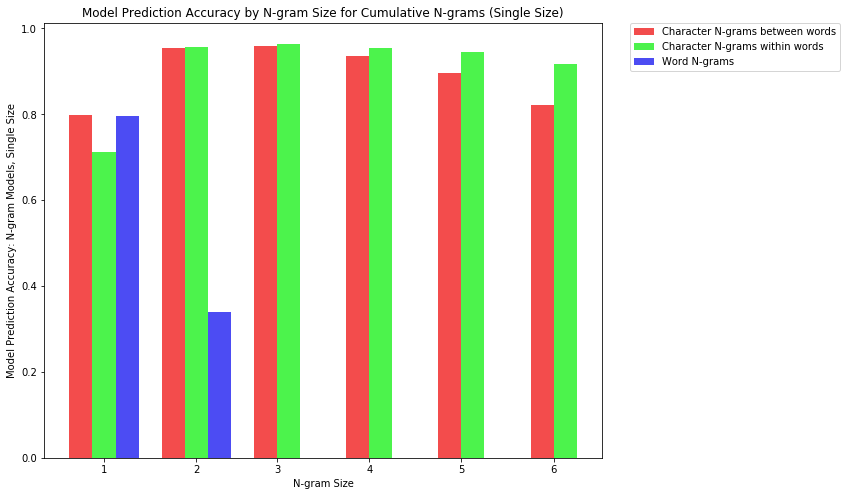

In [22]:
acc_c= []
acc_b= []
acc_w= []
acc_cx= []
acc_bx= []
acc_wx= []

for i in range (n_char_range):
    acc_c.append(accuracy_score(testData[0], pred_ngram_char[i]))
    acc_cx.append(i+1)
for j in range (n_char_range):
    acc_b.append(accuracy_score(testData[0], pred_ngram_char_wb[j]))
    acc_bx.append(j+1.25)    
for k in range (m_word_range):
    acc_w.append(accuracy_score(testData[0], pred_ngram_word[k]))
    acc_wx.append(k+1.5)
    
width = 0.25
fig, ax = plt.subplots(figsize=(10,8))
plt.bar(acc_cx, acc_c, width, alpha=0.7, color='#EE0000')
plt.bar(acc_bx, acc_b, width, alpha=0.7, color='#00EE00')
plt.bar(acc_wx, acc_w, width, alpha=0.7, color='#0000EE')

ax.set_xticks([1.25, 2.25, 3.125, 4.125, 5.125, 6.125])
ax.set_xticklabels(('1', '2', '3', '4', '5', '6'))
plt.legend(['Character N-grams between words', 'Character N-grams within words', 'Word N-grams'], 
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("N-gram Size")
plt.ylabel("Model Prediction Accuracy: N-gram Models, Single Size")
plt.title("Model Prediction Accuracy by N-gram Size for Cumulative N-grams (Single Size)")

plt.show()

<a id="10"></a>
## 10. Analysis of results for cumulative character and word N-grams

It will also be useful to analyze how choice of N-gram size affects the overall model accuracy for cumulative character and word N-grams, i.e. character and word N-grams for which the analysis at a given N-gram size also includes smaller N-gram sizes.

We also use these models' results to analyze the rates of classification errors between closely related language pairs.

### 10a. Bar graph of model accuracy vs. N-gram size (cumulative)

The graph below shows the accuracy of models that used cumulative N-gram size. This graph confirms the following insights: 

- Model accuracy continued to improve as we included larger N-grams into these models. The models did not lose accuracy because larger N-grams were included, as the models using only a single N-gram size did.
- However, the benefits of using character N-gram size larger than N=4 in the cumulative case are very small and might not be worth the extra processing time.
- Using both 1-word and 2-word N-grams in the same model provided no increase in classification accuracy compared with using 1-word N-grams only.

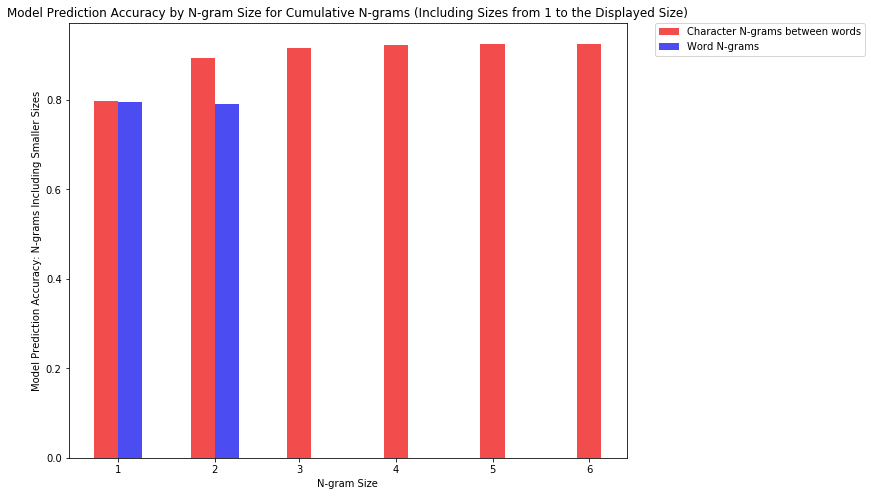

In [15]:
acc_c= []
acc_w= []
acc_cx= []
acc_wx= []

for i in range (n_char_range):
    acc_c.append(accuracy_score(testData[0], pred_ngram_char_cum[i]))
    acc_cx.append(i+1)
for j in range (m_word_range):
    acc_w.append(accuracy_score(testData[0], pred_ngram_word_cum[j]))
    acc_wx.append(j+1.25)
    
width = 0.25
fig, ax = plt.subplots(figsize=(10,8))
plt.bar(acc_cx, acc_c, width, alpha=0.7, color='#EE0000')
plt.bar(acc_wx, acc_w, width, alpha=0.7, color='#0000EE')

ax.set_xticks([1.125, 2.125, 3, 4, 5, 6])
ax.set_xticklabels(('1', '2', '3', '4', '5', '6'))
plt.legend(['Character N-grams between words', 'Word N-grams'], bbox_to_anchor=(1.05, 1), loc=2, 
           borderaxespad=0.)
plt.xlabel("N-gram Size")
plt.ylabel("Model Prediction Accuracy: N-grams Including Smaller Sizes")
plt.title("Model Prediction Accuracy by N-gram Size for Cumulative N-grams (Including Sizes from 1 to the Displayed Size)")

plt.show()

### 10b. Cross-tabulation showing the predicted vs. actual classifications for each language with cumulative character N-grams

The cross-tabulation tables show both the correct and incorrect classifications of languages of passages in the test set. Pre: model prediction. Act: actual language of passage.

There were diminishing returns in accuracy with character N-gram sizes larger than 4 in the cumulative case, but the results for N=6 were best. The results for N=6 are shown below.

We can use these results to arrive at insights regarding the relationships between languages. Passages are more likely to be misclassified as being from similar languages. For example, in decreasing order of frequency, at n=6, there were still relatively high rates of:

- Slovak passages misclassified as Czech 
- Spanish passages misclassified as Portuguese 
- Estonian passages misclassified as Finnish
- Swedish passages misclassified as Danish
- Italian passages misclassified as Romanian 
- Dutch passages misclassified as German
- Italian passages misclassified as Portuguese
- English passages misclassified as Dutch

The variation of these misclassification frequencies with N-gram size is discussed below.

In [23]:
for n in range (n_char_range):
    print('Now processing: Character N-grams within word, N = ' + str(n+1))
    ct=pd.crosstab(testData[0], pred_ngram_char_wb[n], rownames=["Act"], colnames=["Pre"], margins=True)
    ct= pd.DataFrame(ct)
    ct.to_csv('language_detection_crosstab_char_wb' + str(n+1) + '.csv')

for n in range (n_char_range):
    print('Now processing: Cumulative character N-grams, N = ' + str(n+1))
    ct=pd.crosstab(testData[0], pred_ngram_char_cum[n], rownames=["Act"], colnames=["Pre"], margins=True)
    ct= pd.DataFrame(ct)
    ct.to_csv('language_detection_crosstab_char_cum_' + str(n+1) + '.csv')

pd.set_option('display.max_columns',23)
ct

Now processing: Character N-grams within word, N = 1
Now processing: Character N-grams within word, N = 2
Now processing: Character N-grams within word, N = 3
Now processing: Character N-grams within word, N = 4
Now processing: Character N-grams within word, N = 5
Now processing: Character N-grams within word, N = 6
Now processing: Cumulative character N-grams, N = 1
Now processing: Cumulative character N-grams, N = 2
Now processing: Cumulative character N-grams, N = 3
Now processing: Cumulative character N-grams, N = 4
Now processing: Cumulative character N-grams, N = 5
Now processing: Cumulative character N-grams, N = 6


Pre,bg,cs,da,de,el,en,es,et,fi,fr,hu,it,lt,lv,nl,pl,pt,ro,sk,sl,sv,All
Act,,,,,,,,,,,,,,,,,,,,,,
bg,997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,997
cs,1,968,0,1,2,0,0,3,1,0,6,0,2,0,1,3,1,1,0,2,1,993
da,0,0,934,8,4,2,0,1,2,1,10,0,0,0,18,0,1,2,0,0,10,993
de,0,0,8,973,0,2,0,1,1,0,1,0,3,1,2,0,0,0,1,0,0,993
el,0,0,0,0,988,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,988
en,0,14,3,17,0,894,1,9,4,9,5,2,2,2,23,5,7,1,0,0,0,998
es,0,4,1,11,1,1,740,0,2,8,1,5,3,0,15,0,195,6,0,2,0,995
et,0,3,1,6,0,0,1,868,71,0,0,0,20,0,15,0,0,1,0,4,2,992
fi,0,0,0,2,0,0,0,2,989,0,0,0,0,0,1,0,0,0,0,0,0,994


<a id="11"></a>
## 11. Changes in rates of common language misclassifications by size of character N-gram (cumulative)

We stated above that there were diminishing returns in terms of overall accuracy for cumulative character N-grams larger than N=4. But does this remain true for hard-to-distinguish language pairs whose passages are frequently misclassified?

We create a scatterplot of misclassification frequency for all of the frequently misclassified language pairs mentioned above. N-gram size is on the X axis, and misclassification frequency is on the Y axis. The results yield the following insights:

- The misclassification frequency of the frequently misclassified language pairs declines significantly between N-gram sizes N=1 and N=3. 
- After N=4, there are only very small changes in the number of misclassifications. The one exception is Spanish-Portuguese, which dropped from 222 misclassifications to 202 between N=4 and N=5.
- Large numbers of misclassifications for particularly close language pairs remained present even at the highest N-value.  

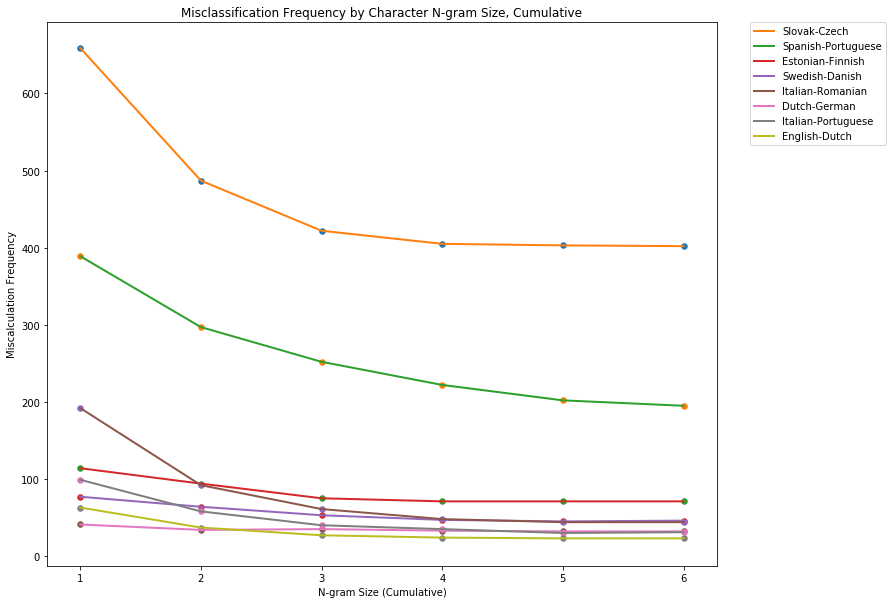

In [28]:
x= [1,2,3,4,5,6]
skcs= [659, 487, 422, 405, 403, 402]
espt= [389, 297, 252, 222, 202, 195]
etfi= [114, 94, 75, 71, 71, 71]
svda= [77, 64, 53, 47, 45, 46]
itro=[192, 92, 61, 48, 44, 44]
nlde=[41, 34, 35, 33, 32, 32]
itpt=[99, 58, 40, 35, 30, 31]
ennl=[63, 37, 27, 24, 23, 23]

fig, ax = plt.subplots(figsize=(12,10))

plt.plot(x, skcs, 'C1', lw=2)
plt.scatter(x, skcs, s=30)
plt.plot(x, espt, 'C2', lw=2)
plt.scatter(x, espt, s=30)
plt.plot(x, etfi, 'C3', lw=2)
plt.scatter(x, etfi, s=30)
plt.plot(x, svda, 'C4', lw=2)
plt.scatter(x, svda, s=30)
plt.plot(x, itro, 'C5', lw=2)
plt.scatter(x, itro, s=30)
plt.plot(x, nlde, 'C6', lw=2)
plt.scatter(x, nlde, s=30)
plt.plot(x, itpt, 'C7', lw=2)
plt.scatter(x, itpt, s=30)
plt.plot(x, ennl, 'C8', lw=2)
plt.scatter(x, ennl, s=30)

plt.legend(['Slovak-Czech', 'Spanish-Portuguese', 'Estonian-Finnish', 'Swedish-Danish', 'Italian-Romanian', 
            'Dutch-German', 'Italian-Portuguese', 'English-Dutch'], bbox_to_anchor=(1.05, 1), loc=2, 
           borderaxespad=0.)
plt.title('Misclassification Frequency by Character N-gram Size, Cumulative')
plt.xlabel("N-gram Size (Cumulative)")
plt.ylabel("Miscalculation Frequency")

plt.show()

<a id="12"></a>
## 12. Changes in rates of common language misclassifications by size of character N-gram (within word)

It would also be informative to repeat the above scatterplot analysis with a series of models for which the accuracy values were higher and showed a different trend type. Therefore, we use the classification results from within-word character N-grams, which had the highest accuracy values.

We use the misclassification frequencies from the same language pairs as above to form a similar scatterplot for within-word character N-gram models. The results, however, yield a different set of insights:

- Although the overall classification accuracy is highest at N=3, the rates of misclassifications for frequently misclassified language pairs keep declining with larger N-gram sizes.
- The fewest errors overall for these difficult classifications are found at N=5.
- Between N=3 and N=6, the number of Slovak passages misclassified as Czech declines from 43 to only 2. The corresponding decline for Swedish passages misclassified as Danish is from 17 to 1. These are huge differences with increasing N-gram size, even though N=6 did not have the highest overall model accuracy.
- The overall drops in both the proportional and absolute numbers of misclassifications are much greater for within-word character N-gram models than for the cumulative character N-gram models shown above.

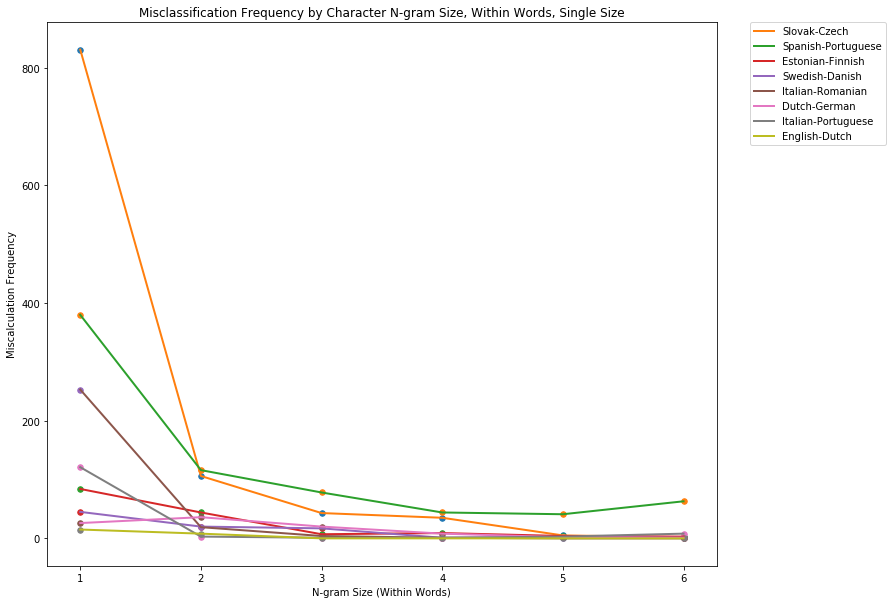

In [29]:
x= [1,2,3,4,5,6]
skcs= [831, 106, 43, 35, 5, 2]
espt= [380, 116, 78, 44, 41, 63]
etfi= [84, 44, 7, 9, 4, 3]
svda= [45, 20, 17, 1, 2, 1]
itro=[253, 19, 4, 1, 0, 0]
nlde=[26, 36, 20, 8, 2, 1]
itpt=[121, 3, 1, 1, 3, 8]
ennl=[15, 8, 0, 0, 0, 0]

fig, ax = plt.subplots(figsize=(12,10))

plt.plot(x, skcs, 'C1', lw=2)
plt.scatter(x, skcs, s=30)
plt.plot(x, espt, 'C2', lw=2)
plt.scatter(x, espt, s=30)
plt.plot(x, etfi, 'C3', lw=2)
plt.scatter(x, etfi, s=30)
plt.plot(x, svda, 'C4', lw=2)
plt.scatter(x, svda, s=30)
plt.plot(x, itro, 'C5', lw=2)
plt.scatter(x, itro, s=30)
plt.plot(x, nlde, 'C6', lw=2)
plt.scatter(x, nlde, s=30)
plt.plot(x, itpt, 'C7', lw=2)
plt.scatter(x, itpt, s=30)
plt.plot(x, ennl, 'C8', lw=2)
plt.scatter(x, ennl, s=30)

plt.legend(['Slovak-Czech', 'Spanish-Portuguese', 'Estonian-Finnish', 'Swedish-Danish', 'Italian-Romanian', 
            'Dutch-German', 'Italian-Portuguese', 'English-Dutch'], bbox_to_anchor=(1.05, 1), loc=2, 
           borderaxespad=0.)
plt.title('Misclassification Frequency by Character N-gram Size, Within Words, Single Size')
plt.xlabel("N-gram Size (Within Words)")
plt.ylabel("Miscalculation Frequency")

plt.show()

<a id="13"></a>
## 13. Overall error rates of attribution to languages by size of character N-gram (within word)

If the rates of misclassification for difficult-to-distinguish language pairs dropped to almost zero at higher N-gram sizes for within-word N-grams, then why did the overall accuracy fall off at N-gram sizes larger than N=3?

Examination of the cross-tabulations for models using within-word N-grams of a single size revealed inaccuracies in the total numbers of passages classified as belonging to certain languages. These inaccuracies worsened in some cases as N increased. We create a scatterplot of the total numbers of passages classified into certain languages for which these trends were noticed.

In the graph below, the total numbers of test passages classified as belonging to each language are normalized by the total numbers of test passsages that were actually in those languages. We derive the following insights from the results:

- More passages are misclassified as Hungarian and Greek as N increases past 3. Much of the model's overall inaccuracy can be attributed to these misclassifications.
- Passages are misclassified as English frequently at N=1, but this problem is largely resolved at higher N values.
- The result of too few passages classified as Slovak was expected, as we already knew that Slovak passages are frequently misclassified as Czech. However, as N increases for within-word N-grams, the number of Slovak passages misclassified as Czech decreases, while the proportion of correctly classified Slovak passages remains too low. The cross-tabulation data show that Slovak passages are more frequently misclassified as Greek and Hungarian at higher values of N.
- Passages from many other languages are also frequently misclassified as Greek and Hungarian as N increases. This is a general problem, as these inaccuracies are not restricted to just one or a few language pairs.



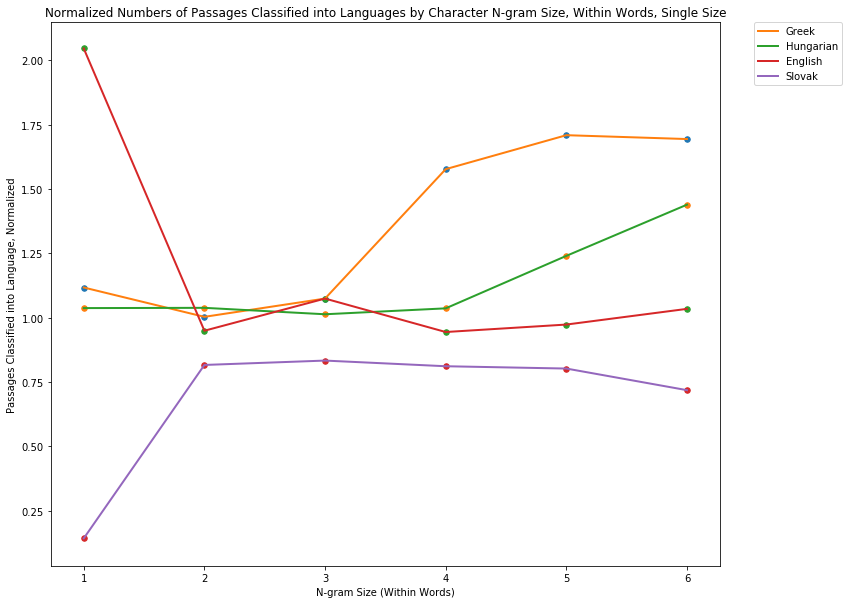

In [30]:
x= [1,2,3,4,5,6]
el= [1.117, 1.003, 1.074, 1.577, 1.709, 1.694]
hu= [1.037, 1.038, 1.013, 1.036, 1.240, 1.439]
en= [2.046, 0.949, 1.074, 0.944, 0.973, 1.034]
sk= [0.142, 0.816, 0.833, 0.811, 0.802, 0.718]

fig, ax = plt.subplots(figsize=(12,10))

plt.plot(x, el, 'C1', lw=2)
plt.scatter(x, el, s=30)
plt.plot(x, hu, 'C2', lw=2)
plt.scatter(x, hu, s=30)
plt.plot(x, en, 'C3', lw=2)
plt.scatter(x, en, s=30)
plt.plot(x, sk, 'C4', lw=2)
plt.scatter(x, sk, s=30)

plt.legend(['Greek', 'Hungarian', 'English', 'Slovak'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Normalized Numbers of Passages Classified into Languages by Character N-gram Size, Within Words, Single Size')
plt.xlabel("N-gram Size (Within Words)")
plt.ylabel("Passages Classified into Language, Normalized")

plt.show()

### 13a. Overall error rates of attribution to languages by size of character N-gram (cumulative)

To check whether the trends revealed by the scatterplot above are unique to within-word N-grams or whether cumulative sets of N-grams that can span between words also show these trends, we repeat the above analysis for cumulative character N-grams.

This scatterplot reveals the following insights: 

- The overall classification rate of passages as Slovak remains too low throughout all N values. This is almost entirely attributable to their misclassification as Czech. 
- High rates of misclassification into the selected languages do not newly emerge as N increases, as they did when we used within-word N-grams above. This shows that the cumulative character N-gram methods effectively prevent new sources of error from emerging when higher N-values are incorporated, although their accuracy ceiling is not as high as that of the within-word character N-gram methods.

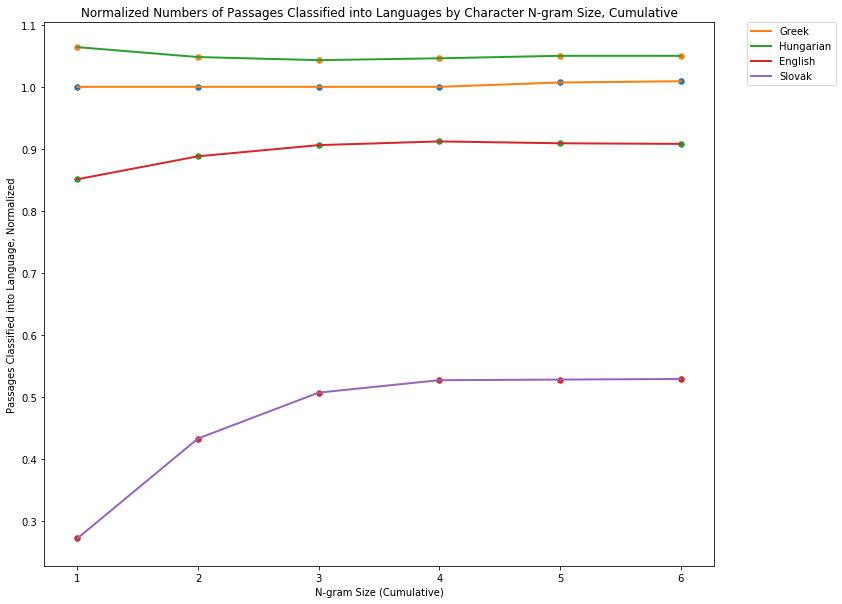

In [31]:
x= [1,2,3,4,5,6]
el= [1.000, 1.000, 1.000, 1.000, 1.007, 1.009]
hu= [1.064, 1.048, 1.043, 1.046, 1.050, 1.050]
en= [0.851, 0.888, 0.906, 0.912, 0.909, 0.908]
sk= [0.272, 0.433, 0.507, 0.527, 0.528, 0.529]

fig, ax = plt.subplots(figsize=(12,10))

plt.plot(x, el, 'C1', lw=2)
plt.scatter(x, el, s=30)
plt.plot(x, hu, 'C2', lw=2)
plt.scatter(x, hu, s=30)
plt.plot(x, en, 'C3', lw=2)
plt.scatter(x, en, s=30)
plt.plot(x, sk, 'C4', lw=2)
plt.scatter(x, sk, s=30)

plt.legend(['Greek', 'Hungarian', 'English', 'Slovak'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Normalized Numbers of Passages Classified into Languages by Character N-gram Size, Cumulative')
plt.xlabel("N-gram Size (Cumulative)")
plt.ylabel("Passages Classified into Language, Normalized")

plt.show()

<a id="13"></a>
## 13. Discussion and Conclusion

Discussions of the major results can be found in the markdown cells above. However, we can provide a brief recap:

- We trained several multinomial logistic regression models with data from the EuroParl parallel corpus to predict the languages of passages from a test set.
- The models employed the N-gram technique by Cavnar, as implemented in Scikit-learn.
- We manipulated several variables to determine their effects on the accuracy of results, including N-gram size, whether or not N-grams could span multiple words, incorporation of multiple vs. single N-gram sizes in the same model, the maximum number of features incorporated in the model, and whether N-grams were built from characters or words.
- We performed analysis of model accuracy and also took a deeper dive into the results. We examined how the rates of common misclassifications varied with N-gram size and model type. We also examined how the overall numbers of passages classified into certain languages varied with N-gram size and model type.
- The results showed that character N-grams within words of size N=3 only had the best accuracy, achieving 96.4% classification accuracy of test passages despite the relative simplicity of the technique.
- The models using character N-grams of a single size that could span between multiple words had accuracy almost as high as those using N-grams within single words.
- Models that used word-based N-grams or restricted the maximum number of features had low accuracy.
- Character N-gram models that were cumulative (i.e. also including N-gram models of all smaller sizes) had increased accuracy at higher N-values, but the benefits diminished at sizes larger than N=4. Their maximum accuracy was lower than that of character N-gram models that employed only a single size of N-gram.
- Certain language pairs had high rates of misclassification at all N-values in the cumulative character N-gram models. The single-size within-word character N-gram models often reduced or eliminated these high-frequency misclassifications at high N-values.
- However, the single-size within-word character N-gram models had lower overall accuracy at the highest N-values because at those large N-gram sizes, increasing numbers of passages tended to be misclassified into certain languages, causing too many passages to be classified into those languages overall.

<a id="14"></a>
## 14. Future Work

### It is possible to pursue many other avenues of investigation related to datasets like this one:

- This method classifies passages based on ranking of N-gram frequency, as per Cavnar 1994. The passage is classified as being in the language that is the shortest distance from it in terms of overall rankings of N-gram frequency. However, it would also be interesting to explore methods based on absolute frequency of N-gram appearance.
- Some of our methods restricted the character N-grams to occur within words and padded the beginnings and endings of words with spaces. Some of the other methods we employed allowed N-grams to span multiple words. However, the training data did not consist entirely of thematically continuous passages. It may improve classification if we selectively prevent N-grams from spanning logically discontinuous texts.
- Some of the training data contained short passages that were not in the assigned languages. For example, some of the training texts in non-English languages contained short English passages. It may help classification if we filter English dictionary words out of the non-English training texts. However, incorporating semantic meaning was outside the scope of this project.
- The test passages in the present test set contained sufficient information to facilitate classification. However, real-world language classification tasks often encounter passages without sufficient information to classify the text, such as very short passages, "junk text," emojis, and mixed language text. Therefore, it would be useful to incorporate the possibility of an "uncertain" outcome if there is insufficient information to arrive at an accurate language classification for a passage. This could be done by implementing a normalization scheme to derive absolute measures of match quality.
- The classifications based on entire words may have suffered because we did not use enough words to generate truly representative statistics. This analysis could be repeated using more of the original data in an attempt to provide better training for word-based classification methods. It was not possible to do so for this project due to the limitations of the available computational resources. To imrpove the results for whole words, it might be ideal to implement a word stemming approach (e.g. recognizing the similarities between 'advance,' 'advanced,' and 'advancement'). 